In [15]:
import os
import json 
import time
import torch
import random
import datetime
import eda_utils
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from torch.nn.functional import softmax
import torch.nn.functional as F
import torch.nn as nn 
from tqdm.auto import tqdm
from os.path import join
from IPython.display import Image
torch.manual_seed(42)
random.seed(42)

# Load files

In [2]:
dt = datetime.datetime.fromtimestamp(time.time())
logdir = os.path.join('./outputs/' ,dt.strftime('%Y-%m-%d_%H:%M:%S'))

print(f'Logging to {logdir}')
if not os.path.exists(logdir):
    os.makedirs(logdir)

path_to_imagenet = '/scratch/users/saarimrahman/imagenet-testbed/outputs'
model_names = eda_utils.model_names
imagenet_dict = eda_utils.imagenet_dict
eval_settings = ['val', 'imagenetv2-matched-frequency']

ensembled_models = [
    'top5_ensemble', 'random5_ensemble', 'top5_random5_ensemble', 
    'class_weighted_top5_ensemble', 'class_weighted_random5_ensemble', 'class_weighted_top5_random5_ensemble',
    'acc_weighted_top5_ensemble', 'acc_weighted_random5_ensemble', 'acc_weighted_top5_random5_ensemble'
]

top_models = [
    'efficientnet-l2-noisystudent', 'FixResNeXt101_32x48d_v2', 'FixResNeXt101_32x48d', 
    'instagram-resnext101_32x48d', 'efficientnet-b8-advprop-autoaug', 'BiT-M-R152x4-ILSVRC2012', 
    'efficientnet-b7-advprop-autoaug', 'instagram-resnext101_32x32d', 'BiT-M-R101x3-ILSVRC2012', 
    'efficientnet-b6-advprop-autoaug', 'efficientnet-b7-randaug', 'efficientnet-b7-autoaug',
    'efficientnet-b5-advprop-autoaug', 'resnext101_32x8d_swsl', 'instagram-resnext101_32x16d',
    'BiT-M-R50x3-ILSVRC2012', 'efficientnet-b6-autoaug', 'FixPNASNet',
    'efficientnet-b5-autoaug', 'efficientnet-b5-randaug', 'resnext101_32x4d_swsl'
]

top5_models = top_models[:5]
print('top5_models', top5_models)
# TODO: random 5 from the top 15-20
random5_models = ['FixPNASNet', 'dpn68', 'fbresnet152', 'pnasnet5large', 'vgg19']


Logging to ./outputs/2021-05-11_20:16:27
top5_models ['efficientnet-l2-noisystudent', 'FixResNeXt101_32x48d_v2', 'FixResNeXt101_32x48d', 'instagram-resnext101_32x48d', 'efficientnet-b8-advprop-autoaug']


In [3]:
def load_logits_targets(models_to_load):
    logits = defaultdict(dict)
    targets = {}
    output_folders = os.listdir(path_to_imagenet)
    for model in tqdm(models_to_load, desc='load_logits_targets', leave=False):
        for eval_setting in ['val', 'imagenetv2-matched-frequency']:
            output_folder = model + '-' + eval_setting
            if output_folder in output_folders:
                model_targets = os.path.join(path_to_imagenet, output_folder, 'targets.pt')
                model_logits = os.path.join(path_to_imagenet, output_folder, 'logits.pt')
                if os.path.exists(model_logits):
                    logits[eval_setting][model] = torch.load(model_logits)
                if eval_setting not in targets and os.path.exists(model_targets):
                    targets[eval_setting] = torch.load(model_targets)
    return logits, targets

def find_missing_logits(models, eval_setting='val'):
    print(f'Checking for missing {eval_setting} logits...')
    on_disk, missing = [], []
    output_folders = os.listdir(path_to_imagenet)
    for model in models:
        output_folder = model + '-' + eval_setting
        if output_folder in output_folders:
            model_logits = os.path.join(path_to_imagenet, output_folder, 'logits.pt')
            if os.path.exists(model_logits):
                on_disk.append(model)
            else:
                missing.append(model)
        else:
            missing.append(model)
    print(len(missing), 'models missing:', missing)
    return on_disk, missing


find_missing_logits(top5_models + random5_models, 'val')
find_missing_logits(top5_models + random5_models, 'imagenetv2-matched-frequency')

find_missing_logits(top_models[:5], 'val')
find_missing_logits(top_models[:5], 'imagenetv2-matched-frequency')

logits, targets = load_logits_targets(top5_models + random5_models)


Checking for missing val logits...
0 models missing: []
Checking for missing imagenetv2-matched-frequency logits...
0 models missing: []
Checking for missing val logits...
0 models missing: []
Checking for missing imagenetv2-matched-frequency logits...
0 models missing: []


load_logits_targets:   0%|          | 0/10 [00:00<?, ?it/s]

# Helper Functions

In [4]:
def accuracy_topk(logits, targets, topk=1):
    batch_size = targets.size(0)

    _, pred = logits.topk(topk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(targets.view(1, -1).expand_as(pred))

    correct_k = correct[:topk].view(-1).float().sum(0, keepdim=True)
    return correct_k.mul_(100.0 / batch_size).item()

def find_correct(logits, targets, topk=1):
    """Returns a boolean tensor showing correct predictions"""
    batch_size = targets.size(0)

    _, pred = logits.topk(topk, 1, True, True)
    pred = pred.t()
    return pred.eq(targets.view(1, -1).expand_as(pred))

def get_pred(logits, topk=1):
    _, pred = logits.topk(topk, 1, True, True)
    return pred.t()
    
def num_pairwise_errors(x_correct, y_correct):
    """Finds the number of shared elements incorrectly classified for x and y"""
    
    assert x_correct.size() == y_correct.size(), 'x and y are not the same size'
    x_error_idx = (x_correct == False).nonzero(as_tuple=True)[1]
    y_error_idx = (y_correct == False).nonzero(as_tuple=True)[1]
    return len(np.intersect1d(x_error_idx, y_error_idx))

def pairwise_corrcoef(x_logits, y_logits):
    """Applies softmax to each row of 50000 entries, flattens, then calculates correlation
    Note: Logits are originally of shape torch.Size([50000, 1000])
    """
    sigmoid_x = torch.nn.functional.softmax(x_logits, dim=1).flatten().numpy()
    sigmoid_y = torch.nn.functional.softmax(y_logits, dim=1).flatten().numpy()
    return np.corrcoef(sigmoid_x, sigmoid_y)[0][1]

def partition(data, eval_setting='val'):
    return train_test_split(data, test_size=0.5, stratify=targets[eval_setting], random_state=42)
    
def view_image(index, eval_setting='val'):
    datasets_path = '/scratch/users/saarimrahman/imagenet-testbed/s3_cache/datasets'
    eval_data_path = join(datasets_path, eval_setting)
    num_img_per_class = targets[eval_setting].size(0) // 1000
    folder_idx = index // num_img_per_class 
    img_idx = index % num_img_per_class
    folder = sorted(os.listdir(eval_data_path))[folder_idx]
    folder_path = join(eval_data_path, folder)
    file_name = sorted(os.listdir(folder_path))[img_idx]
    img_path = join(folder_path, file_name)
    print('true class:', imagenet_dict[index // num_img_per_class])
    display(Image(filename=img_path))
    
def sort_dict(dic):
    return dict(sorted(dic.items(), key=lambda item: item[1], reverse=True))

# Ensemble

In [5]:
def get_ensemble_logits(softmax_pred):
    """Construct ensemble logits from a tensor containing all ensemble model's softmax predictions."""
    ensemble_logits = []
    for i in range(softmax_pred.size(1)): # 50000 examples
        logit = torch.mean(softmax_pred[:, i, :], 0)
        ensemble_logits.append(logit)
    
    return torch.stack(ensemble_logits)

def ensemble_models(models, eval_setting='val'):
    softmax_pred, pred = [], []
    
    for model in models:
        softmax_pred.append(softmax(logits[eval_setting][model], dim=1))
    softmax_pred = torch.stack(softmax_pred)
    
    return get_ensemble_logits(softmax_pred)

def majority_vote_models(models):
    pred = get_pred(logits['val'][models[0]])
    for model in models[1:]:
        pred = torch.cat((pred, get_pred(logits['val'][model])), 0)
    return torch.mode(pred, 0, keepdim=True)[0]

for eval_setting in ['val', 'imagenetv2-matched-frequency']:
    logits[eval_setting]['top5_ensemble'] = ensemble_models(top5_models, eval_setting)
    logits[eval_setting]['random5_ensemble'] = ensemble_models(random5_models, eval_setting)
    logits[eval_setting]['top5_random5_ensemble'] = ensemble_models(top5_models + random5_models, eval_setting)

In [6]:
def class_weighted_ensemble(models, eval_setting='val'):
    """Weights each model's softmax predictions based on its relative accuracy in the class.
    Uses half of the class images to calculate in class accuracy. 
    """
    w = [] 
    for model in models:
        class_acc = []
        pred = get_pred(logits[eval_setting][model])
        miss = pred.eq(targets[eval_setting].view(1, -1).expand_as(pred)).float().flatten()
        total_images = targets[eval_setting].size(0)
        step_size = total_images // 1000
        i = 0
        while i < total_images:
            class_acc.append(miss[i:i+(step_size // 2)].sum().item() / (step_size // 2)) # calculate relative in class accuracy
            i += step_size
        w.append(torch.tensor(class_acc))
        
    w = torch.stack(w)
    
    weighted_softmax_pred = []
    for i, model in enumerate(models):
        probs = softmax(logits[eval_setting][model], dim=1)
        weighted_pred = torch.mul(probs, w[i])
        weighted_softmax_pred.append(weighted_pred) 
    
    weighted_softmax_pred = torch.stack(weighted_softmax_pred)
    return get_ensemble_logits(weighted_softmax_pred)

for eval_setting in ['val', 'imagenetv2-matched-frequency']:
    logits[eval_setting]['class_weighted_top5_ensemble'] = class_weighted_ensemble(top5_models, eval_setting)
    logits[eval_setting]['class_weighted_random5_ensemble'] = class_weighted_ensemble(random5_models, eval_setting)
    logits[eval_setting]['class_weighted_top5_random5_ensemble'] = class_weighted_ensemble(top5_models + random5_models, eval_setting)

In [7]:
def acc_weighted_ensemble(models, eval_setting='val'):
    """Weights each model's softmax predictions based on its overall accuracy on the dataset.
    Uses half of the dataset to calculate overall accuracy.
    """
    eval_targets_train, eval_targets_test = partition(targets[eval_setting], eval_setting)

    weighted_softmax_pred = []
    for model in models:
        train_logit, _ = partition(logits[eval_setting][model], eval_setting)
        acc = accuracy_topk(train_logit, eval_targets_train)
        probs = softmax(logits[eval_setting][model], dim=1)
        weighted_pred = torch.mul(probs, acc)
        weighted_softmax_pred.append(weighted_pred) 
        
    weighted_softmax_pred = torch.stack(weighted_softmax_pred)
    return get_ensemble_logits(weighted_softmax_pred)

for eval_setting in ['val', 'imagenetv2-matched-frequency']:
    logits[eval_setting]['acc_weighted_top5_ensemble'] = acc_weighted_ensemble(top5_models, eval_setting)
    logits[eval_setting]['acc_weighted_random5_ensemble'] = acc_weighted_ensemble(random5_models, eval_setting)
    logits[eval_setting]['acc_weighted_top5_random5_ensemble'] = acc_weighted_ensemble(top5_models + random5_models, eval_setting)

# Sampling Analysis

In [77]:
# here, X and Y are classes
def sd_classifier_acc(model, eval_setting, num_classes=1000, num_iters=10000):
# model = 'top5_ensemble'
# eval_setting = 'val'
    rng = np.random.default_rng(42)

    # take all 50 ims for each class, computed only once
    # E[X] = acc for a class over the 50 images (b/w 0-1)
    exp = []

    pred = get_pred(logits[eval_setting][model])
    miss = pred.eq(targets[eval_setting].view(1, -1).expand_as(pred)).float().flatten()
    total_images = targets[eval_setting].size(0)
    step_size = total_images // 1000
    i = 0
    for i in range(num_classes):
        exp.append(miss[i*step_size: (i+1)*step_size].sum().item() / step_size) # calculate relative in class accuracy

    # E[X, Y]
    joint_exp = np.zeros((num_classes, num_classes))  


    for _ in range(num_iters):
        for x in range(num_classes):
            for y in range(x, num_classes):
                # randomly select 10 from each class WITHOUT replacement
                x_imgs = rng.choice(miss[x*step_size: (x+1)*step_size], size=10, replace=False)
                x_acc = x_imgs.sum().item() / 10
                y_imgs = rng.choice(miss[y*step_size: (y+1)*step_size], size=10, replace=False)
                y_acc = y_imgs.sum().item() / 10

                 # E[X, Y] = multiply pairwise for each class
                joint_exp[x, y] += x_acc * y_acc

                # utilize symmetry to populate matrix
                if x != y:
                    joint_exp[y, x] = joint_exp[x, y]                    

    # then average over num_iters repetitions to get entries into the final matrix
    joint_exp = joint_exp / num_iters

    # Cov[X, Y]
    cov = np.zeros((num_classes, num_classes))
    for x in range(num_classes):
        for y in range(x, num_classes):
            if x == y: 
                # diagonal entries: E[X] * (1 - E[X])
                cov[x, y] = exp[x] * (1 - exp[x])
            else:
                # off-diagonal: Cov[X, Y] = E[X, Y] - E[X] * E[Y]
                cov[x, y] = joint_exp[x, y] - exp[x] * exp[y]
                # utilize symmetry to populate matrix
                cov[y, x] = cov[x, y] 


    np.savetxt((join(logdir, f'{model}_{eval_setting}_cov.csv')), cov, delimiter=",")

    # standard error is sqrt(Sum of all entries in the cov matrix/ num entries in the cov matrix)
    std_err = np.sqrt(np.sum(cov)) / num_classes
    print(f'[{model}, {eval_setting}] standard error: {std_err}')
    return std_err

In [ ]:
for model in ['efficientnet-l2-noisystudent', 'vgg19']:
    for eval_setting in eval_settings:
        sd_classifier_acc(model, eval_setting, num_classes=50, num_iters=1000)

In [94]:
df=pd.read_csv(join(logdir, 'top5_ensemble_val_cov.csv'), sep=',',header=None)

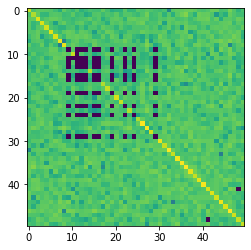

In [103]:
plt.imshow(np.log(np.abs(df.values + 1e-10)));

In [107]:
df = df.style.background_gradient()
df

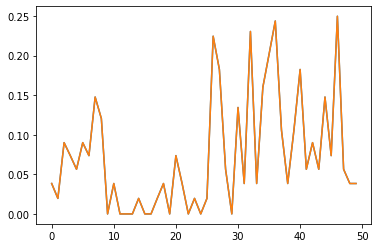

In [88]:
plt.plot([df.values[i, i] for i in range(50)])
plt.show();

In [105]:
for k in np.arange(10, 60, 10):
    print(k, np.sqrt(sum([df.values[i, i] for i in range(k)]) / k**2))

10 0.08423775875461074
20 0.04543126676640219
30 0.04000000000000001
40 0.041355168963504434
50 0.03860362677262332


In [97]:
np.sum(df.values)

3.780469999948349

In [98]:
np.sum(np.abs(df.values))

5.5775179999972835